# Save Amazon Rainforest!
### An Introduction to the problem
In 2019, there were severe rainforest fires in the Amazon rainforest. Reading the news about this fire, our group is wondering given that the government did not react to the rainforest fire on time and there has already been a scaled firing area, what would be the minimum cost needed to control the fire to a specific range? In particular, we want to determine at each time t (calculated in days that has a range from 1 to 30) how much resources (including labor, helicopters, and supertankers in our problem) we should use in order to control the burning area to be less than the initial burning area or less than third times of the initial burning area depending on the case we are discussing, subject to several constraints including the total number of labors and airplanes, direction of fire expansion, and the space we want to control the fire. In other words, our objective is to use resources to control the fire in a month and minimize the total cost for doing that.

### Model formulation and Description of the approach used
#### Formulation
We simplify the region we are considering to 2000km2 square-shaped forest. The fundamental feature of our model is that we divide the square area into 20*20 small square grids format. For each grid at each time t, it can utilize certain amount of resources to put off fire $labor(i,j,t), heli(i,j,t)$ which are our variables and at each given time we model its burning area. Instead of thinking about modelling how the initial firing area will expand and how firemen and airplanes will traverse through the graph to encompass the firing area each day over 30-day time period, we turn this stochatic graphic problem into an algebraic equivalence: we construct a function that outputs the burning area of each grid (i to indicate which grid) at a given time t:<br>
\$ \hspace{2cm}BurningArea(grid_{i,j,t}) = BurningArea(grid_{i,j,t-1}) + F(fireExpand_{i,j,t}) - G(firefight_{i,j,t}),\$<br> where $F(fireExpand_{i,j,t})$ is the area of fire expansion which is distributed as uniform(0.5,1) km2 and $G(firefight_{i,j,t})$ is total area of fire that can be put off by labors and airplanes at time t. <br>
<br>
Note: We record the burning area of each grid at each time period in the variable "burningArea(i,j,t)", which is the amount of burning area in each grid(i,j) at time t. Notice it by construction is not a percentage, but you can easily get the percentage of burning area of each grid through dividing burningArea(i,j,t) by gridArea.<br>
<br>
We tried to solve different versions of the problem, from simple to considering more complicated factors. Specifically, we have 6 cases/models. In the first case, we assume the fire cannot expand outside the initial burning grids, which is not very plausible. Then, for cases 2,3 we include cases that fire can expand to other forest grids, but to different directions and start at different locations. Finally, in case 4 we include the policy used in firefighting in our model; and we consider further that there exists a time lag on labor response for putting off fire in subcase 1.1 and 2.1. In all, we develop our fire-expansion-and-firefight models in a step-by-step and simple-to-difficult manner. At each scenario we are adding different features compared to previous models.  For all models below, we formulate the forest into grid area, where burningArea refers to the area of that grid that is on fire at that time period.<br>
#### More Information
Since we divide the forest into grids format, each grid in our model represents a certain area of forest, and the "gridArea" scalar in our model indicates how large the forest area of each grid is. In our model if one grid is involved with an initial fire, this does not mean that the entire forest area of that grid is on fire. Rather, we model that if one grid is involved with initial fire, 50% of the grid forest area is initially burning. This gives the chance that fire in the initial burning grid can grow within that grid. For example, at initial time "T1", only 50% of grid(i,j) is burning, but if there is no fireman or firefighting helicopter is there to put off fire at grid(i,j) in time "T1", in the next time period "T2" the burning forest area within that grid(i,j) can grow (or say "expand") to 60% of the forest area of that grid(i,j). <br>
#### Approaches
In our model, we have binary variables called $burn(i,j,t)$ which determines whether the grid (i,j) has burning area or not at time t and $expand(i,j,t)$ which determines whether the fire will expand to other grid at time t. We use many proposition and constraint conversions in our model, and we also use bigM method to determine relationship between burn and burningArea for each grid at each time (refer to lecture 19 & 20). Since we are using binary variables and labor and helicopters are all integer variables, we use mip to solve the problem. For visualization part, we use graph to display the amount of burning area in each grid. In all following graphs the darker the red is, the more area amount of that forest grid is on fire. The background pink-ish color does not mean there is firing area in that grid, the background pink-ish color refers as NO fire burning on those grids. We graph the fire burning area in different time periods and use the sequence of graphs to show how fire expands and gets controlled by firefight resources over time. 

#### ***NOTICE: for our codes, the outputs generated by gams and jupyter notebook are very different (at least on the jupyter notebook server that we are using). We went to the office hour for this problem, but we haven't found a solution. Hence, please refer to the gams file provided in .zip to regenerate outputs. The output listed in jupyter notebook here is not our final solution nor what we used for generating graphs. The graph we plot here are generated from the gdx file we generate from gams file. We add gdx here for visualization purpose.

In [1]:
# Load the gams extension
%load_ext gams_magic

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors

#### scenario 1: fire is only growing within the burning grids, and does not expand to other grids that did not burn in the initial time period.

We start from the simple case where fire is only growing within the initially burning grids. In other words, for grids that have initial burning area, the amount of burning area in each of those grids can get larger within those grids, but for grids that did not burn at the initial time snapshot (i.e. grids that do not have initial fire), they will not burn in the following time periods either and fire in initial burning grids will not expand to them. In reality, we can think of this as the case that fire expansion has already been well controlled by firemen, for example through digging, scraping, and constructing non-flammable barriers on the outer boundary of burning forest area, so that fire will not expand to other forest areas that are not burning at the beginning, and in this case the only thing left for firemen and firefight aircrafts is to put off fire in this initial burning forest area.

In [3]:
%%gams
# data and variable set up
** consider the case of fire not expand
set i "horizontal division of forest area" /1*20/
    j "vertical division of forest area" /1*20/
    t "thirty days to firefight" /T1*T30/
;

** forest area consideration scope
scalar
    totalArea "total forest area by summing over all grids",
    gridArea "forest area one grid represents",
    delta "threshold for fire in one grid to naturally die out due to unpredicted weather and soil conditions"
;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification
scalar
    totalLabor "total firemen that can be deployed for firefight at each time" /44000/
    totalHeli  "total helicopters available for firefight at each time period" /150/
    laborE   "fire km squared that one fireman can put off in one day" /0.0005/
    heliE    "fire km squared that one helicopter can put off in one day" /0.02/
    laborCost  "fireman wage per day in dollar" /68.43/
    heliCost   "helicopter cost per day in dollar" /38300/
;

parameter
    fireExpandArea(i,j,t) "the area amount that fire within one grid can grow or expand between two consecutive time";
option seed=101;
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost "total cost government need to spend on controlling wildfire";
binary variable
    burn(i,j,t) "indicate whether one forest grid has any burning area"
;
positive variable burningArea(i,j,t) "the amount of burning area within one forest grid";
integer variable
    labor(i,j,t) "amount of firemen deployed at each time on each grid"
    heli(i,j,t) "amount of helicopter deployed at each time on each grid"
;

labor.lo(i,j,t) = 0;
heli.lo(i,j,t) = 0;

** initial burning area to be given below
scalar initialBurningArea;

In [4]:
%%gams
# equations and model set up
** modelling equations section
equations
objective "cost calculation"
burnConstr1 "turn off burn indicator if fire burning area in previous period can naturally die out"
burnConstr2 "keep on burn indicator if fire burning area in previous period cannot naturally die out"
burningAreaTrans "burningArea state transition equation between two consecutive time"
burningBurnConstr "burn and burningArea consistency"
laborCapConstr "firemen deployed less than capacity limit"
heliCapConstr  "helicopter deployed less than capacity limit"
timeSpaceConstr "at the final time period amount of burning area less than initial burning area amount"
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (1 - burn(i,j,t)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * burn(i,j,t) =l= delta - burningArea(i,j,t-1)
;
   
burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t)
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE - delta
;

laborCapConstr(t)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(t)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

timeSpaceConstr(t)$(ord(t) = card(t))..
    sum((I,J), burningArea(I,J,T)) =l= initialBurningArea
;

model localfire /objective,burnConstr1,burnConstr2,burningAreaTrans,burningBurnConstr,
laborCapConstr,heliCapConstr,timeSpaceConstr/;

In [5]:
%%gams
# model solution
** Solve model given initial burning area
burn.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
initialBurningArea = 0.5 * 15 * gridArea;

option reslim = 300;
option optcr = 0.05;
option solver = gurobi;
solve localfire using mip min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),4709694.75,46862,48001,MIP,GUROBI,0.508


In [6]:
%%gams
positive variable burningArea1,labor1,heli1;
$gdxin localfire.gdx
$load burningArea
$load labor
$load heli
$gdxin

In [7]:
%gams_pull -d burningArea labor heli
display(labor.query("level > 0"),heli.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
7351,13,6,T2,100.0,68.43,0.0,inf,1.0
7352,13,6,T3,100.0,68.43,0.0,inf,1.0
7353,13,6,T4,77.0,68.43,0.0,inf,1.0
7354,13,6,T5,100.0,68.43,0.0,inf,1.0
7355,13,6,T6,100.0,68.43,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
8668,15,9,T29,100.0,68.43,0.0,inf,1.0
8669,15,9,T30,69.0,68.43,0.0,inf,1.0
8671,15,10,T2,100.0,68.43,0.0,inf,1.0
8672,15,10,T3,100.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
7351,13,6,T2,37.0,38300.0,0.0,inf,1.0
7352,13,6,T3,32.0,38300.0,0.0,inf,1.0
7353,13,6,T4,9.0,38300.0,0.0,inf,1.0
7354,13,6,T5,31.0,38300.0,0.0,inf,1.0
7355,13,6,T6,51.0,38300.0,0.0,inf,1.0
7389,13,7,T10,35.0,38300.0,0.0,inf,1.0
7401,13,7,T22,9.0,38300.0,0.0,inf,1.0
7402,13,7,T23,15.0,38300.0,0.0,inf,1.0
7404,13,7,T25,30.0,38300.0,0.0,inf,1.0
7416,13,8,T7,22.0,38300.0,0.0,inf,1.0


In [8]:
df = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df.columns = col_names

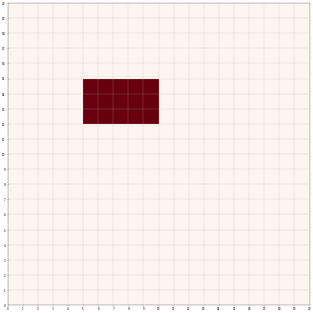

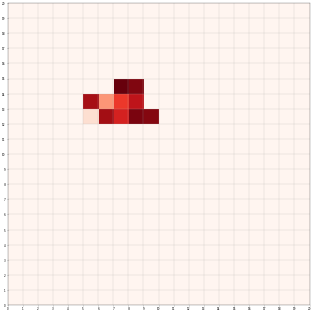

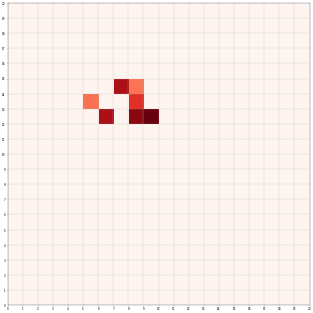

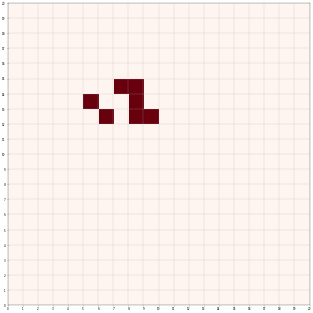

In [9]:
df1 = df[df['time']=='T1']
data = df1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df2 = df[df['time']=='T6']
data = df2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df3 = df[df['time']=='T15']
data = df3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df4 = df[df['time']=='T30']
data = df4['area']
new_data = np.array(data.values)
data4 = np.split(new_data, 20)
# plt.imshow(df1['area'],interpolation='none',cmap='Blues',origin='lower')  
# plt.show
w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data4)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

#### ***NOTICE: in the graph the darker the red is, the more area of that grid is on fire, and the background pink-ish color does not mean there is firing area in that grid, those background pink-ish color refers as NO fire burning on those grids. SAME FOR ALL ABOVE AND BELOW.

#### Scenario 1.1: time lag on labor response in the scenario 1 model.
In the previous scenario, we assume that firemen and labor can respond to fire instantaneously. Yet in reality although helicopters can still act instantaneous to firing at the same day, firemen may not be able to respond to fire burning in one grid on time, due to cases like thay have not yet construct enough non-flammable barriers on that grid or they cannot travel to that grid at the same day. To consider this factors, we set up a time lag for labor reactions to firing such that labor can only extinguish area that was burning five days ago. The rule follows: $if$ firemen discover a burning spot in one grid, or a burning spot in any of the four adjacent grids, $then$ the labor will be able to firefight on that grid after five days. We will first try this labor time lag in the scenario 1 localfire model.

In [10]:
%%gams
** consider the case of fire not expand
set i "horizontal division of forest area" /1*20/
    j "vertical division of forest area" /1*20/
    t "thirty days to firefight" /T1*T30/
;

** forest area consideration scope
scalar
    totalArea "total forest area by summing over all grids",
    gridArea "forest area one grid represents",
    delta "threshold for fire in one grid to naturally die out due to unpredicted weather and soil conditions"
;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification
scalar
    totalLabor "total firemen that can be deployed for firefight at each time" /44000/
    totalHeli  "total helicopters available for firefight at each time period" /150/
    laborE   "fire km squared that one fireman can put off in one day" /0.0005/
    heliE    "fire km squared that one helicopter can put off in one day" /0.02/
    laborCost  "fireman wage per day in dollar" /68.43/
    heliCost   "helicopter cost per day in dollar" /38300/
;

parameter
    fireExpandArea(i,j,t) "the area amount that fire within one grid can grow or expand between two consecutive time";
option seed=101;
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost "total cost government need to spend on controlling wildfire";
binary variable
    burn(i,j,t) "indicate whether one forest grid has any burning area"
;
positive variable burningArea(i,j,t) "the amount of burning area within one forest grid";
integer variable
    labor(i,j,t) "amount of firemen deployed at each time on each grid"
    heli(i,j,t) "amount of helicopter deployed at each time on each grid"
;

labor.lo(i,j,t) = 0;
heli.lo(i,j,t) = 0;

** initial burning area to be given below
scalar initialBurningArea;

** modelling equations section
equations
objective "cost calculation"
burnConstr1 "turn off burn indicator if fire burning area in previous period can naturally die out"
burnConstr2 "keep on burn indicator if fire burning area in previous period cannot naturally die out"
burningAreaTrans "burningArea state transition equation between two consecutive time"
burningBurnConstr "burn and burningArea consistency"
laborCapConstr "firemen deployed less than capacity limit"
heliCapConstr  "helicopter deployed less than capacity limit"
timeSpaceConstr "at the final time period amount of burning area less than initial burning area amount"
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (1 - burn(i,j,t)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * burn(i,j,t) =l= delta - burningArea(i,j,t-1)
;
   
burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t)
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE - delta
;

laborCapConstr(t)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(t)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

timeSpaceConstr(t)$(ord(t) = card(t))..
    sum((I,J), burningArea(I,J,T)) =l= initialBurningArea
;

equations timeLaborConstr,timeHeliConstr;

timeLaborConstr(i,j,t)..
    labor(i,j,t) =l= (burn(i,j,t-5) + burn(i+1,j,t-5) + burn(i-1,j,t-5) + burn(i,j-1,t-5) + burn(i,j+1,t-5)) * totalLabor
;

timeHeliConstr(i,j,t)..
    heli(i,j,t) =l= burn(i,j,t) * totalHeli
;

model localfire1 /objective,burnConstr1,burnConstr2,burningAreaTrans,burningBurnConstr,
laborCapConstr,heliCapConstr,timeSpaceConstr,timeLaborConstr,timeHeliConstr/;

burn.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
initialBurningArea = 0.5 * 15 * gridArea;

option reslim = 300;
option optcr = 0.05;
option solver = gurobi;
solve localfire1 using mip min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),6768958.74,70862,48001,MIP,GUROBI,0.456


In [11]:
%%gams
positive variable burningArea11,labor11,heli11;
$gdxin localfire1.gdx
$load burningArea
$load labor
$load heli
$gdxin

In [12]:
%gams_pull -d burningArea labor heli
display(labor.query("level > 0"),heli.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
7385,13,7,T6,100.0,68.43,0.0,inf,1.0
7386,13,7,T7,100.0,68.43,0.0,inf,1.0
7387,13,7,T8,100.0,68.43,0.0,inf,1.0
7388,13,7,T9,100.0,68.43,0.0,inf,1.0
7389,13,7,T10,100.0,68.43,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
8665,15,9,T26,100.0,68.43,0.0,inf,1.0
8666,15,9,T27,100.0,68.43,0.0,inf,1.0
8667,15,9,T28,100.0,68.43,0.0,inf,1.0
8668,15,9,T29,100.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
7351,13,6,T2,34.0,38300.0,0.0,inf,1.0
7352,13,6,T3,97.0,38300.0,0.0,inf,1.0
7389,13,7,T10,23.0,38300.0,0.0,inf,1.0
7399,13,7,T20,25.0,38300.0,0.0,inf,1.0
7400,13,7,T21,50.0,38300.0,0.0,inf,1.0
7406,13,7,T27,1.0,38300.0,0.0,inf,1.0
7415,13,8,T6,3.0,38300.0,0.0,inf,1.0
7416,13,8,T7,51.0,38300.0,0.0,inf,1.0
7417,13,8,T8,78.0,38300.0,0.0,inf,1.0
7454,13,9,T15,40.0,38300.0,0.0,inf,1.0


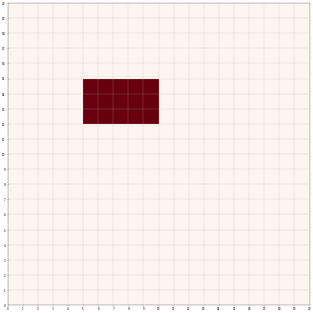

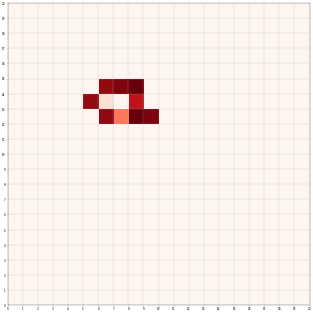

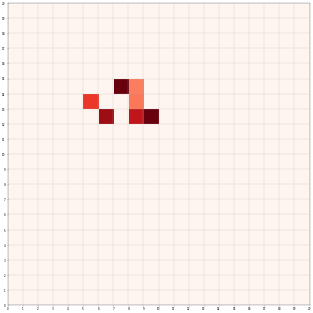

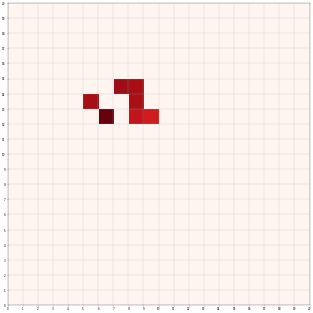

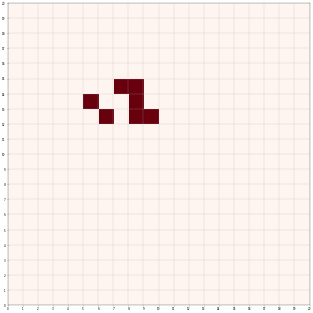

In [13]:
df_try6 = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df_try6.columns = col_names

df_try6_1 = df_try6[df_try6['time']=='T1']
data = df_try6_1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try6_2 = df_try6[df_try6['time']=='T7']
data = df_try6_2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try6_3 = df_try6[df_try6['time']=='T15']
data = df_try6_3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try6_3 = df_try6[df_try6['time']=='T21']
data = df_try6_3['area']
new_data = np.array(data.values)
data4 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data4)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try6_3 = df_try6[df_try6['time']=='T30']
data = df_try6_3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

#### Scenario 2: fire can not only grow within the initially burning grids, but can also expand to other grids that do not have any initial burning area.

In this scenario, we add the flexibility that fire in the initial firing grids can expand to its adjacent grids no matter whether that adjacent grid is initially on fire or not. We also consider the unpredicted weather and soil conditions by setting a "delta" threshold, such that if the previous-period burning area is less than 10% of total grid area, then in the next time period, that fire will naturally die out due to for example rainfall and high soil moisture. The feature/rule of fire expansion we add in this scenario is formulated specifically as the following:
1. $if$ the forest grid has burning area in the pervious period, and the burning area in the previous period is LESS the delta threshould, $then$ in this period the burning area in that grid will die out (become 0).
2. $if$ the forest grid has burning area in the pervious period, and the burning area in the previous period is MORE than the delta threshould, $then$ in this period the burning area in that grid can still grow and expand (stay positive).
3. $if$ the forest grid does NOT have burning area in the pervious period, and any one of its four adjacent grid has burning area in the pervious period, $then$ in this period this grid will have fire burning that is expanded from its adjacent grid, with the fire expansion amount having a discount factor 40% of the original expansion amount. We consider the fire expansion amount discount factor because different grid can have forest type (dense,open,transitional), and this can slow down the fire expansion speed.
4. $if$ the forest grid does NOT have burning area in the pervious period, and NONE of its four adjacent grid has burning area in the pervious period, $then$ in this period this forest grid still will NOT have any burning area.

For this scenario, because we allow for fire expansion to other grids in all four directions, the fire expansion over grids is so fast that if we still set the time period to be T1 to T30 the model may not return a solution in 10 minutes (Another reason for this is because we have new variable "expand" and more constraints on expansion rule to consider). With this consideration, we shorten the time period to T1~T10.

In [14]:
%%gams

** consider the case that fire can expand to other grids
set i /1*20/
    j /1*20/
    t "short time period for this scenario" /T1*T10/
;

** forest area consideration scope
scalar totalArea, gridArea, delta;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification on "per day in km2 basis"
scalar
    totalLabor /44000/
    totalHeli  /150/
    laborE   /0.0005/
    heliE    /0.02/
    laborCost  /68.43/
    heliCost   /38300/
;

parameter fireExpandArea(i,j,t);
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost;
binary variable
    burn(i,j,t)
;
positive variable burningArea(i,j,t);
integer variable
    labor(i,j,t)
    heli(i,j,t)
;

labor.lo(i,j,t) = 0; heli.lo(i,j,t) = 0;

scalar initialBurningArea;

** addition of variable in previous case
binary variable
    expand(i,j,t) "whether will fire expand to other grid"
;

** modelling
equations
objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr1,expandConstr2,expandConstr3,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
laborMatching,heliMatching,timeSpaceConstr
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (2 - burn(i,j,t) - burn(i,j,t-1)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * (1 - burn(i,j,t-1) + burn(i,j,t)) =l= delta - burningArea(i,j,t-1)
;

burnConstr3(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + expand(i,j,t) =l= 1 + burn(i,j,t)
;

burnConstr4(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + 1 - expand(i,j,t) =l= 2 - burn(i,j,t)
;

expandConstr1(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i+1,j,t-1)
;

expandConstr2(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i-1,j,t-1)
;

expandConstr3(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j+1,t-1)
;

expandConstr4(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j-1,t-1)
;

expandConstr5(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =l= burn(i+1,j,t-1) + burn(i-1,j,t-1) + burn(i,j+1,t-1) + burn(i,j-1,t-1)
;

burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t) * (0.4 + 0.6*burn(i,j,t-1))
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE - delta * burn(i,j,t-1)
;

laborCapConstr(T)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(T)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

laborMatching(I,J,T)$(ord(T) lt card(T))..
    labor(I,J,T) =l= (burn(I,J,T) + burn(I+1,J,T) + burn(I-1,J,T) + burn(I,J-1,T) + burn(I,J+1,T)) * totalLabor
;

heliMatching(I,J,T)$(ord(T) lt card(T))..
    heli(I,J,T) =l= burn(I,J,T) * totalHeli
;

timeSpaceConstr(T)$(ord(T) = card(T))..
    sum((I,J), burningArea(I,J,T)) =l= 3 * initialBurningArea
;

model allExpandFire /objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr1,expandConstr2,expandConstr3,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
laborMatching,heliMatching,timeSpaceConstr/;

** solution to model
burn.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 13 and ord(J) le 15) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 13 or ord(J) gt 15) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 13 and ord(J) le 15) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 13 or ord(J) gt 15) = 0;
initialBurningArea = 0.5 * 9 * gridArea;

option reslim = 600;
option optcr = 0.05;
option solver=gurobi;
solve allExpandFire using mip min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),424060.71,47222,19601,MIP,GUROBI,26.239


In [15]:
%%gams
positive variable burningArea2,labor2,heli2;
$gdxin allExpandFire.gdx
$load burningArea
$load labor
$load heli
$gdxin

In [16]:
%gams_pull -d burningArea labor heli
display(labor.query("level > 0"),heli.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
729,4,13,T10,100.0,68.43,0.0,inf,1.0
739,4,14,T10,100.0,68.43,0.0,inf,1.0
749,4,15,T10,100.0,68.43,0.0,inf,1.0
919,5,12,T10,100.0,68.43,0.0,inf,1.0
959,5,16,T10,100.0,68.43,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
3929,20,13,T10,100.0,68.43,0.0,inf,1.0
3939,20,14,T10,100.0,68.43,0.0,inf,1.0
3949,20,15,T10,100.0,68.43,0.0,inf,1.0
3969,20,17,T10,100.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
2916,15,12,T7,1.0,38300.0,0.0,inf,1.0


In [17]:
df_try2 = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df_try2.columns = col_names

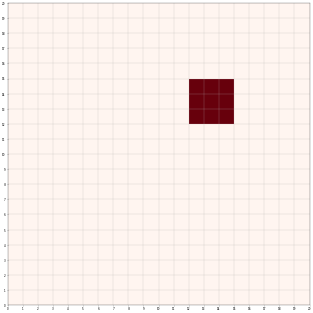

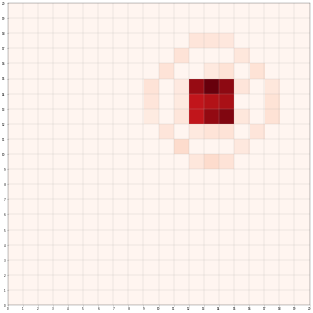

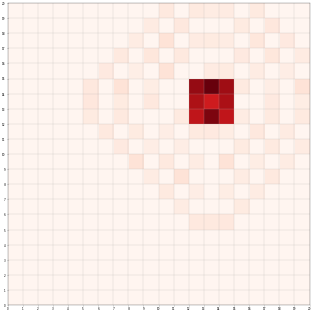

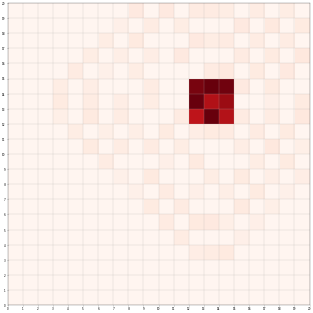

In [18]:
df_try2_1 = df_try2[df_try2['time']=='T1']
data = df_try2_1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try2_2 = df_try2[df_try2['time']=='T4']
data = df_try2_2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try2_3 = df_try2[df_try2['time']=='T8']
data = df_try2_3['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try2_4 = df_try2[df_try2['time']=='T10']
data = df_try2_4['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

#### Scenario 2.1: time lag on labor response in the scenario 2 model.
Same idea and additional feature as in Scenario 1.1

In [19]:
%%gams

** consider the case that fire can expand to other grids
set i /1*20/
    j /1*20/
    t "short time period for this scenario" /T1*T10/
;

** forest area consideration scope
scalar totalArea, gridArea, delta;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification on "per day in km2 basis"
scalar
    totalLabor /44000/
    totalHeli  /150/
    laborE   /0.0005/
    heliE    /0.02/
    laborCost  /68.43/
    heliCost   /38300/
;


scalar
    totalSuper /4/
    superE     /1/
    superCost  /25000/;

parameter fireExpandArea(i,j,t);
option seed=101;
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost;
binary variable
    burn(i,j,t)
;
positive variable burningArea(i,j,t);
integer variable
    labor(i,j,t)
    heli(i,j,t)
;

labor.lo(i,j,t) = 0; heli.lo(i,j,t) = 0;

scalar initialBurningArea;

** addition of variable in previous case
binary variable
    expand(i,j,t) "whether will fire expand to other grid"
;

** modelling
equations
objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr1,expandConstr2,expandConstr3,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
laborMatching,heliMatching,timeSpaceConstr,timeLaborConstr
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (2 - burn(i,j,t) - burn(i,j,t-1)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * (1 - burn(i,j,t-1) + burn(i,j,t)) =l= delta - burningArea(i,j,t-1)
;

burnConstr3(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + expand(i,j,t) =l= 1 + burn(i,j,t)
;

burnConstr4(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + 1 - expand(i,j,t) =l= 2 - burn(i,j,t)
;

expandConstr1(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i+1,j,t-1)
;

expandConstr2(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i-1,j,t-1)
;

expandConstr3(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j+1,t-1)
;

expandConstr4(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j-1,t-1)
;

expandConstr5(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =l= burn(i+1,j,t-1) + burn(i-1,j,t-1) + burn(i,j+1,t-1) + burn(i,j-1,t-1)
;

burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t) * (0.4 + 0.6*burn(i,j,t-1))
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE - delta * burn(i,j,t-1)
;

laborCapConstr(T)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(T)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

laborMatching(I,J,T)$(ord(T) lt card(T))..
    labor(I,J,T) =l= (burn(I,J,T) + burn(I+1,J,T) + burn(I-1,J,T) + burn(I,J-1,T) + burn(I,J+1,T)) * totalLabor
;

heliMatching(I,J,T)$(ord(T) lt card(T))..
    heli(I,J,T) =l= burn(I,J,T) * totalHeli
;

timeSpaceConstr(T)$(ord(T) = card(T))..
    sum((I,J), burningArea(I,J,T)) =l= 3 * initialBurningArea
;

timeLaborConstr(i,j,t)..
    labor(i,j,t) =l= (burn(i,j,t-5) + burn(i+1,j,t-5) + burn(i-1,j,t-5) + burn(i,j-1,t-5) + burn(i,j+1,t-5)) * totalLabor
;

model allExpandFire1 /objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr1,expandConstr2,expandConstr3,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
heliMatching,timeSpaceConstr,timeLaborConstr/;

** solution to model
burn.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 13 and ord(J) le 15) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 13 or ord(J) gt 15) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 13 and ord(J) le 15) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 13 or ord(J) gt 15) = 0;
initialBurningArea = 0.5 * 9 * gridArea;

option reslim = 600;
option optcr = 0.05;
option solver=gurobi;
solve allExpandFire1 using mip min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),537722.94,47622,19601,MIP,GUROBI,7.335


In [20]:
%%gams
positive variable burningArea21,labor21,heli21;
$gdxin allExpandFire1.gdx
$load burningArea
$load labor
$load heli
$gdxin

In [21]:
%gams_pull -d burningArea labor heli
display(labor.query("level > 0"),heli.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
1529,8,13,T10,100.0,68.43,0.0,inf,1.0
1539,8,14,T10,100.0,68.43,0.0,inf,1.0
1549,8,15,T10,100.0,68.43,0.0,inf,1.0
1719,9,12,T10,100.0,68.43,0.0,inf,1.0
1759,9,16,T10,100.0,68.43,0.0,inf,1.0
...,...,...,...,...,...,...,...,...
3719,19,12,T10,100.0,68.43,0.0,inf,1.0
3759,19,16,T10,100.0,68.43,0.0,inf,1.0
3929,20,13,T10,100.0,68.43,0.0,inf,1.0
3939,20,14,T10,53.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
2098,11,10,T9,1.0,38300.0,0.0,inf,1.0
2496,13,10,T7,2.0,38300.0,0.0,inf,1.0
2954,15,16,T5,1.0,38300.0,0.0,inf,1.0
3088,16,9,T9,1.0,38300.0,0.0,inf,1.0
3544,18,15,T5,1.0,38300.0,0.0,inf,1.0
3588,18,19,T9,2.0,38300.0,0.0,inf,1.0


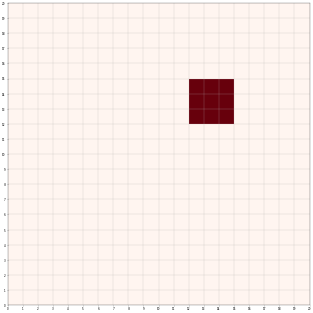

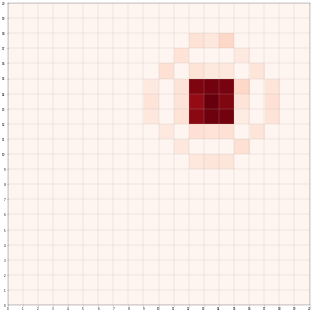

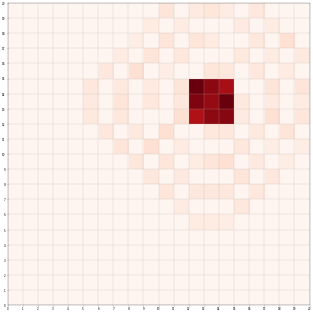

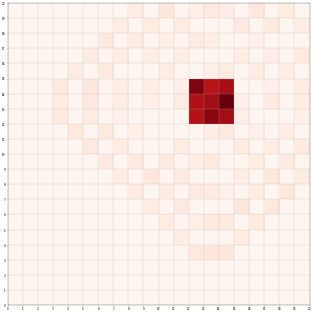

In [22]:
df_try7 = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df_try7.columns = col_names

df_try7_1 = df_try7[df_try7['time']=='T1']
data = df_try7_1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try7_2 = df_try7[df_try7['time']=='T4']
data = df_try7_2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try7_3 = df_try7[df_try7['time']=='T8']
data = df_try7_3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try7_4 = df_try7[df_try7['time']=='T10']
data = df_try7_4['area']
new_data = np.array(data.values)
data4 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data4)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

We can see with the lagged labor firefight response, the fire expansion area is larger, especially at time "T4".

#### Scenario 3: fire can not only grow within the initially burning grids, but can also expand to other grids that are not any initial burning FROM CERTAIN DIRECTIONS.
This scenario is a specific case of scenario 2, meaning that all expansion rules are the same except the expansion now just need to consider specific directions. Notice that in scenario 2, since fire can expand to all four directions, we limit our time period to T1\~T10. In this case we limit fire expansion directions to be only right and upward. The time period is changed back to T1~T30.

In [23]:
%%gams

** consider the case that fire can expand to other grids
set i /1*20/
    j /1*20/
    t /T1*T30/
;

** forest area consideration scope
scalar totalArea, gridArea, delta;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification on "per day in km2 basis"
scalar
    totalLabor /44000/
    totalHeli  /150/
    laborE   /0.0005/
    heliE    /0.02/
    laborCost  /68.43/
    heliCost   /38300/
;

parameter fireExpandArea(i,j,t);
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost;
binary variable
    burn(i,j,t)
;
positive variable burningArea(i,j,t);
integer variable
    labor(i,j,t)
    heli(i,j,t)
;

labor.lo(i,j,t) = 0; heli.lo(i,j,t) = 0;

scalar initialBurningArea;

** addition of variable in previous case
binary variable
    expand(i,j,t) "whether will fire expand to other grid"
;


** modelling
equations
objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr1,expandConstr2,expandConstr3,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
laborMatching,heliMatching,timeSpaceConstr
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (2 - burn(i,j,t) - burn(i,j,t-1)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * (1 - burn(i,j,t-1) + burn(i,j,t)) =l= delta - burningArea(i,j,t-1)
;

burnConstr3(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + expand(i,j,t) =l= 1 + burn(i,j,t)
;

burnConstr4(i,j,t)$(ord(t) gt 1)..
    1 - burn(i,j,t-1) + 1 - expand(i,j,t) =l= 2 - burn(i,j,t)
;

expandConstr1(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i+1,j,t-1)
;

expandConstr2(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i-1,j,t-1)
;

expandConstr3(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j+1,t-1)
;

expandConstr4(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =g= burn(i,j-1,t-1)
;

expandConstr5(i,j,t)$(ord(t) gt 1)..
    expand(i,j,t) =l= burn(i+1,j,t-1) + burn(i-1,j,t-1) + burn(i,j+1,t-1) + burn(i,j-1,t-1)
;

burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t) * (0.4 + 0.6*burn(i,j,t-1))
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE - delta * burn(i,j,t-1)
;

laborCapConstr(T)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(T)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

laborMatching(I,J,T)$(ord(T) lt card(T))..
    labor(I,J,T) =l= (burn(I,J,T) + burn(I+1,J,T) + burn(I-1,J,T) + burn(I,J-1,T) + burn(I,J+1,T)) * totalLabor
;

heliMatching(I,J,T)$(ord(T) lt card(T))..
    heli(I,J,T) =l= burn(I,J,T) * totalHeli
;

timeSpaceConstr(T)$(ord(T) = card(T))..
    sum((I,J), burningArea(I,J,T)) =l= 3 * initialBurningArea
;

model directedExpandFire /objective,burnConstr1,burnConstr2,burnConstr3,burnConstr4,
expandConstr2,expandConstr4,expandConstr5,
burningAreaTrans,burningBurnConstr,laborCapConstr,heliCapConstr,
laborMatching,heliMatching,timeSpaceConstr/;

** solution to model
burn.fx(I,J,"T1")$(ord(I) ge 14 and ord(I) le 15 and ord(J) ge 14 and ord(J) le 15) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 14 or ord(I) gt 15 or ord(J) lt 14 or ord(J) gt 15) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 14 and ord(I) le 15 and ord(J) ge 14 and ord(J) le 15) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 14 or ord(I) gt 15 or ord(J) lt 14 or ord(J) gt 15) = 0;
initialBurningArea = 0.5 * 4 * gridArea;

option reslim = 600;
option optcr = 0.05;
option solver=gurobi;
solve directedExpandFire using mip min cost;

,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),1269239.64,128062,59601,MIP,GUROBI,46.515


In [24]:
%%gams
positive variable burningArea3,labor3,heli3;
$gdxin directedExpandFire.gdx
$load burningArea
$load labor
$load heli
$gdxin

In [25]:
%gams_pull -d burningArea labor heli
display(labor.query("level > 0"),heli.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
8191,14,14,T2,76.0,68.43,0.0,inf,1.0
8192,14,14,T3,100.0,68.43,0.0,inf,1.0
8221,14,15,T2,61.0,68.43,0.0,inf,1.0
8222,14,15,T3,100.0,68.43,0.0,inf,1.0
8791,15,14,T2,100.0,68.43,0.0,inf,1.0
8792,15,14,T3,100.0,68.43,0.0,inf,1.0
8793,15,14,T4,77.0,68.43,0.0,inf,1.0
8821,15,15,T2,100.0,68.43,0.0,inf,1.0
8822,15,15,T3,88.0,68.43,0.0,inf,1.0
8823,15,15,T4,100.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
8191,14,14,T2,27.0,38300.0,0.0,inf,1.0
8192,14,14,T3,100.0,38300.0,0.0,inf,1.0
8221,14,15,T2,100.0,38300.0,0.0,inf,1.0
8222,14,15,T3,12.0,38300.0,0.0,inf,1.0
8791,15,14,T2,23.0,38300.0,0.0,inf,1.0
8792,15,14,T3,38.0,38300.0,0.0,inf,1.0
8793,15,14,T4,60.0,38300.0,0.0,inf,1.0
8823,15,15,T4,90.0,38300.0,0.0,inf,1.0
8824,15,15,T5,56.0,38300.0,0.0,inf,1.0


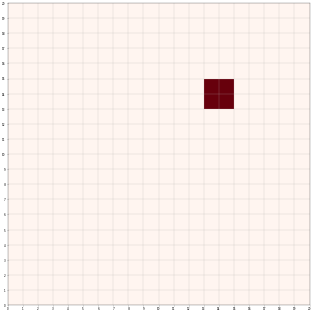

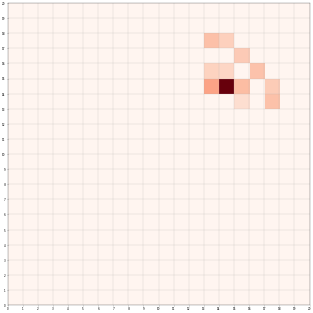

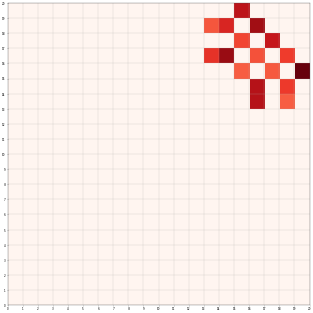

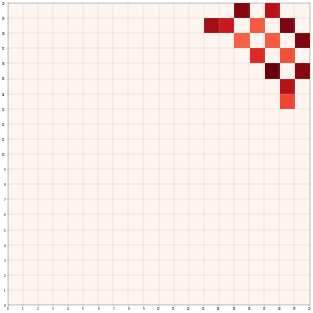

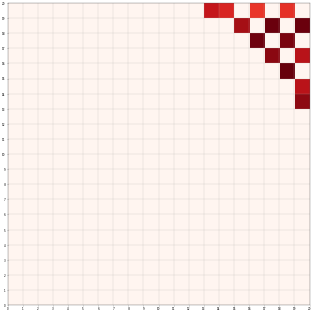

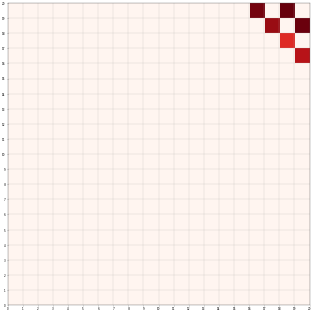

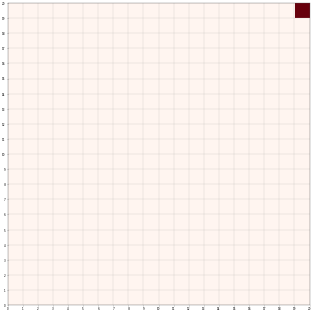

In [26]:
df_try4 = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df_try4.columns = col_names

df_try4_1 = df_try4[df_try4['time']=='T1']
data = df_try4_1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try4_2 = df_try4[df_try4['time']=='T4']
data = df_try4_2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try4_3 = df_try4[df_try4['time']=='T7']
data = df_try4_3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try4_4 = df_try4[df_try4['time']=='T9']
data = df_try4_4['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try4_5 = df_try4[df_try4['time']=='T10']
data = df_try4_5['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try4_6 = df_try4[df_try4['time']=='T22']
data = df_try4_6['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try4_7 = df_try4[df_try4['time']=='T29']
data = df_try4_7['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

#### Scenario 4: Policy changes -- Chile support Brazil with 4 additional boeing 747 firefighting supertanker.
In this scenario, there is additional firefighting resources provided by Chile. This can be regarded as a form of unilateral international support. Since boeing supertanker can carry about 20000 gallons of water, much more water than helicopters, we set the efficiency of super tanker to be 50 times than that of a helicopter (close to real case), so that if that supertanker is used on one burning grid, that grid is very much likely to be extinguished.

Originally, we are thinking about modelling policy changes in the fire expansion scenario, but because there are more variables and constraints added with existence of supertanker, and the fire expansion itself is already hard to control, things get ugly very quickly and we cannot get a solution within five minutes under 5% relative gap. With this concern, we decide to use scenario 1 model format and set a larger initial burning area for this policy problem.

In [36]:
%%gams
** consider the case of fire not expand
set i  /1*20/
    j  /1*20/
    t  /T1*T30/
;

** forest area consideration scope
scalar
    totalArea,
    gridArea,
    delta
;
totalArea = 2000;
gridArea = totalArea / (card(i)*card(j));
delta = 0.1 * gridArea;

** resource specification
scalar
    totalLabor /44000/
    totalHeli  /150/
    laborE /0.0005/
    heliE  /0.02/
    laborCost /68.43/
    heliCost  /38300/
;

scalar
    totalSuper /4/
    superE     /1/
    superCost  /25000/
;

parameter
    fireExpandArea(i,j,t);
option seed=101;
fireExpandArea(i,j,t) = uniform(0.5,1);

free variable cost;
binary variable
    burn(i,j,t)
;
positive variable burningArea(i,j,t);
integer variable
    labor(i,j,t) 
    heli(i,j,t)
    sup(i,j,t)
;

labor.lo(i,j,t) = 0;
heli.lo(i,j,t) = 0;
sup.lo(i,j,t) = 0;

** initial burning area to be given below
scalar initialBurningArea;

** modelling equations section
equations
objective
burnConstr1
burnConstr2
burningAreaTrans 
burningBurnConstr 
laborCapConstr 
heliCapConstr  
timeSpaceConstr 
superCapConstr
superMatching
;

objective..
    cost =e= sum((i,j,t), labor(i,j,t)*laborCost + heli(i,j,t)*heliCost + sup(i,j,t)*superCost)
;

burnConstr1(i,j,t)$(ord(t) gt 1)..
    gridArea * (1 - burn(i,j,t)) =g= delta - burningArea(i,j,t-1)
;

burnConstr2(i,j,t)$(ord(t) gt 1)..
    (-gridArea) * burn(i,j,t) =l= delta - burningArea(i,j,t-1)
;
   
burningBurnConstr(i,j,t)..
    burningArea(i,j,t) =l= burn(i,j,t) * gridArea
;
 
burningAreaTrans(i,j,t)$(ord(t) gt 1)..
    burningArea(i,j,t) + gridArea * (1 - burn(i,j,t)) =g= fireExpandArea(i,j,t)
                            + burningArea(i,j,t-1) - labor(i,j,t)*laborE - heli(i,j,t)*heliE
                            - sup(i,j,t)*superE - delta * burn(i,j,t-1)
;

superMatching(I,J,T)..
    sup(I,J,T) =l= burn(I,J,T) * totalSuper
;

superCapConstr(T)..
    sum((I,J), sup(I,J,T)) =l= totalSuper
;

laborCapConstr(T)..
    sum((I,J), labor(I,J,T)) =l= totalLabor
;

HeliCapConstr(T)..
    sum((I,J), Heli(I,J,T)) =l= totalHeli
;

timeSpaceConstr(T)$(ord(T) = card(T))..
    sum((I,J), burningArea(I,J,T)) =l= initialBurningArea
;

model policyFire /all/;

** Solve model given initial burning area
burn.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 1;
burn.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
burningArea.fx(I,J,"T1")$(ord(I) ge 13 and ord(I) le 15 and ord(J) ge 6 and ord(J) le 10) = 0.5 * gridArea;
burningArea.fx(I,J,"T1")$(ord(I) lt 13 or ord(I) gt 15 or ord(J) lt 6 or ord(J) gt 10) = 0;
initialBurningArea = 0.5 * 15 * gridArea;

option reslim = 300;
option optcr = 0.05;
option solver = gurobi;
* jupyter notebook has significantly different output in this model
* solve policyFire using mip min cost;

In [32]:
%%gams
positive variable burningArea4,labor4,heli4,sup4;
$gdxin policyFire.gdx
$load burningArea
$load labor
$load heli
$load sup
$gdxin

In [33]:
%gams_pull -d burningArea labor heli sup
display(labor.query("level > 0"),sup.query("level > 0"))

,i,j,t,level,marginal,lower,upper,scale
7951,14,6,T2,11.0,68.43,0.0,inf,1.0
8012,14,8,T3,100.0,68.43,0.0,inf,1.0
8016,14,8,T7,54.0,68.43,0.0,inf,1.0
8551,15,6,T2,54.0,68.43,0.0,inf,1.0


,i,j,t,level,marginal,lower,upper,scale
7355,13,6,T6,1.000000,25000.0,0.0,inf,1.0
7356,13,6,T7,2.000000,25000.0,0.0,inf,1.0
7388,13,7,T9,4.000000,25000.0,0.0,inf,1.0
7419,13,8,T10,4.000000,25000.0,0.0,inf,1.0
7451,13,9,T12,2.000000,25000.0,0.0,inf,1.0
7452,13,9,T13,2.000000,25000.0,0.0,inf,1.0
7472,13,10,T3,3.000000,25000.0,0.0,inf,1.0
7951,14,6,T2,2.000000,25000.0,0.0,inf,1.0
7982,14,7,T3,1.000000,25000.0,0.0,inf,1.0
7983,14,7,T4,1.000000,25000.0,0.0,inf,1.0


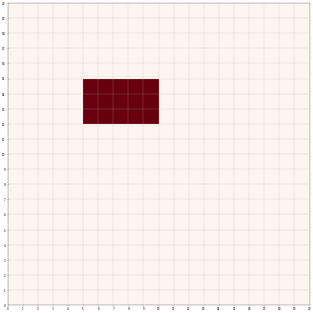

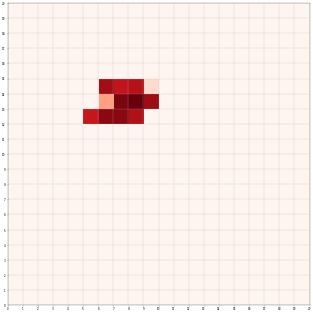

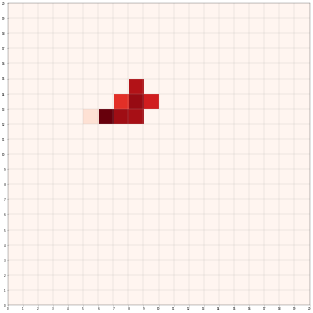

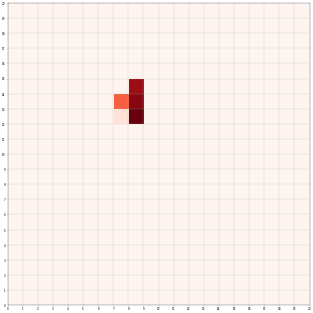

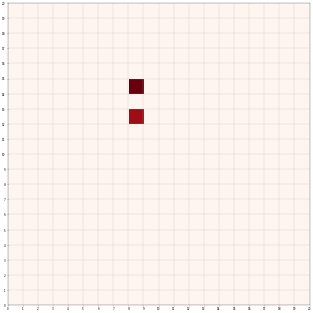

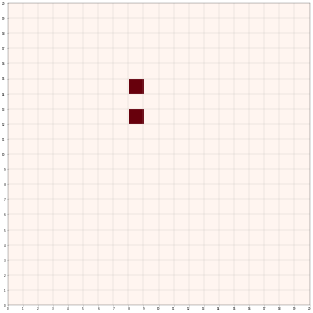

In [35]:
df_try5 = pd.DataFrame(data=burningArea)
col_names = ['from', 'to', 'time','area','marginal','lower','upper','scale']
df_try5.columns = col_names

df_try5_1 = df_try5[df_try5['time']=='T1']
data = df_try5_1['area']
new_data = np.array(data.values)
data1 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data1)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try5_2 = df_try5[df_try5['time']=='T4']
data = df_try5_2['area']
new_data = np.array(data.values)
data2 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data2)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try5_3 = df_try5[df_try5['time']=='T7']
data = df_try5_3['area']
new_data = np.array(data.values)
data3 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data3)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try5_4 = df_try5[df_try5['time']=='T10']
data = df_try5_4['area']
new_data = np.array(data.values)
data4 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data4)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])


plt.grid()
plt.show()

df_try5_5 = df_try5[df_try5['time']=='T25']
data = df_try5_5['area']
new_data = np.array(data.values)
data5 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data5)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()

df_try5_6 = df_try5[df_try5['time']=='T30']
data = df_try5_6['area']
new_data = np.array(data.values)
data6 = np.split(new_data, 20)

w = 20
h = 20
d = 20
fig=plt.figure(figsize=(w, h), dpi=d)

ax = fig.gca()
ax.set_xticks(np.arange(0, 21, 1))
ax.set_yticks(np.arange(0, 21, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,20)

color_map = plt.imshow(data6)
color_map.set_cmap("Reds")
color_map.set_extent([0,20,20,0])

plt.grid()
plt.show()


With the more efficient super tanker assistance from other nation, compared to scenario 1 visualization, we can find the fire burning area is better contracted over time periods.

### Conclusion
From our models, we have the following discoveries:<br>
<1> Time lag is a significant factor in determining the optimal cost to control wildfire. With firemen reaction lagged behind the fire expansion, the cost of firefight increases dramatically, from 77,349,218 to 82,897,809 dollars in the local fire scenarios (scenario1 VS. 1.1), and from 825,860 to 952,516 (scenario 2). Notice that in scenario 2 the time consideration is from 1 to 10, so that's one reason that the cost in scenario 2 is smaller than cost in scenario 1.<br>
<2> Policy support of additional resources can be another factor to decrease the cost needed to control fire, from 77,349,218 to 1,264,986. This may not be close to the real-world expenses decrease in number (because we also consider the unilateral transfer from G7 countries in the cost of supertanker as well, refer to our pdf explanation), but it echoes with what in the news that supertankers provided by Chile improves the fire control situation in Brazil a lot.<br>

### Extension

For now, our model is a much simplified firefight model compared to the real case, where there are more complicated fire-expansion considerations, such as how fire is connected with soil moisture, wind speed, and temperature, and how labor can actually go to each forest grid (i.e. the path modelling of firemen in forest). Also, we encountered problems on modelling fire expansion. The model is very sensitive to the timeSpaceConstr and fire expansion area. In the office hour, we got advice on doing a pre-model in deciding the range of fire expansion area that allows firefight resources to control the burning amount, but due to time limit we haven't got a good plan/idea in this part. If time permits, in the future we want to study more on stochastic processing, and model more carefully on the fire expansion part. We do get some insights from this problem, but there are more to be done and improved in future!

additional material link:<br>
[fire expansion](http://www.eufirelab.org/toolbox2/library/upload/235.pdf)<br>
[math model fire spread](https://www.fs.fed.us/rm/pubs_int/int_rp115.pdf)